# Parameter Retrieval 4: Using parameter functions

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to:

- obtain static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.
- use functions to represent model parameters

> **NOTE:** to run this example you need the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = False, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)        # Incidence angles
N = np.random.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)       # NormBRDF values

phi = np.linspace(0, 2.* np.pi, num)[:,np.newaxis]

sim_params = dict(k=2.5, dphi=np.random.randint(0, 200)/100, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4, phi=phi, PI=np.pi)    # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(omega=[0.2], k=[1], N=[0.1]*num, dphi=[1])
bnd_vals = dict(omega=[(0.01, 0.5)], k=[(0.5, 5.)], N=[(0.01, 0.5)]*num, dphi=[(0., np.pi)])

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.NormBRDF = "N + 2*N**2"
R.tau = "k * (phi + dphi) / (2*PI) * sin(phi + dphi)**(2)"

R.set_geometry(t_0=np.deg2rad(inc), p_0=0, geometry="mono")
tot = R.calc(**sim_params, **const_params)[0]

# Add some random noise
tot += np.random.normal(0, noise_sigma, tot.shape)

17:24:13.039 INFO: Evaluating coefficients for interaction-term...
17:24:13.156 INFO: Coefficients extracted, it took 0.01347 sec.


## Setup scipy optimize to fit RT1 model to the data

In [5]:
from scipy.sparse import csr_matrix, vstack, block_diag

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], k=x[1], dphi=x[2], N=x[3:][:, np.newaxis])

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)
    res = R.calc()[0] - tot
    
    # Ravel output because scipy requires 1D arrays
    return res.ravel()

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)
    jac = R.jacobian(param_list=["omega", "k", "dphi", "N"])

    # Reshape jacobian to fit scipy.optimize requirements
    # (e.g. a 2D matrix of the shape (# measurements, # parameters) where each 
    # column represents the derivatives with respect to the optimized parameter)
    jac_columns = []
    # The first 3 parameters (omega, k, dphi) are affected by all measurements, 
    # so the corresponding rows of the scipy-jacobian is given by the ravelled 
    # rt1-jacobian values.
    jac_columns += csr_matrix(jac[0].ravel())
    jac_columns += csr_matrix(jac[1].ravel())
    jac_columns += csr_matrix(jac[2].ravel())
    # The last parameter (N) represents a timeseries of independent variables
    # (e.g. one value for each timestamp). 
    # Therefore we need to convert the rt1-jacobian into a block-diagonal
    # matrix so that each parameter is only affected by the values 
    # of the corresponding timestamp.
    jac_columns += block_diag(jac[3].tolist(), "csr")

    return vstack(jac_columns).T

# Unpack start-values and boundaries as required by scipy optimize
x0 = [*start_vals["omega"], *start_vals["k"], *start_vals["dphi"], *start_vals["N"]]
bounds = list(zip(*[*bnd_vals["omega"], *bnd_vals["k"], *bnd_vals["dphi"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    #x_scale="jac",
    ftol=1e-5,
    gtol=1e-5,
    xtol=1e-5,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

print([key, np.mean(val)] for key, val in found_params.items())


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4718e+00                                    4.79e+00    
       1              2         5.1358e-01      3.96e+00       3.84e-01       2.08e+00    
       2              3         2.7906e-01      2.35e-01       2.99e-01       1.94e+00    
       3              4         1.5238e-01      1.27e-01       3.34e-01       1.60e+00    
       4              5         1.0061e-01      5.18e-02       2.19e-02       4.13e-01    
       5              7         8.1002e-02      1.96e-02       1.31e-01       6.31e-01    
       6              8         5.3397e-02      2.76e-02       1.34e-01       4.23e-01    
       7              9         3.7504e-02      1.59e-02       1.37e-01       3.31e-01    
       8             10         2.4529e-02      1.30e-02       1.33e-01       3.42e-01    
       9             11         1.8328e-02      6.20e-03       1.29e-01       3.34e-01    

## Visualize Results
### Plot timeseries

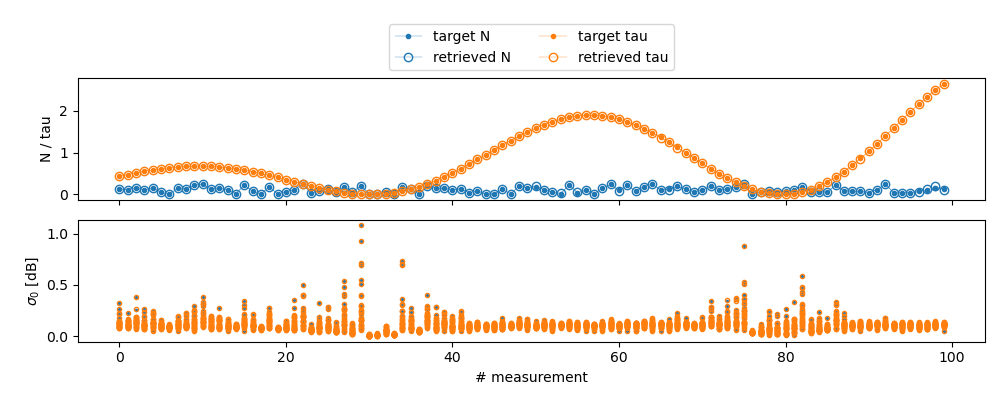

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)

# Plot retrieved parameter timeseries
ax.set_ylabel("N / tau")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0")

R.update_params(**sim_params, **const_params)
ax.plot(R.tau, marker=".", lw=0.25, label="target tau", c="C1")
R.update_params(**found_params, **const_params)
ax.plot(R.tau, marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1")

# Plot backscatter timeseries
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

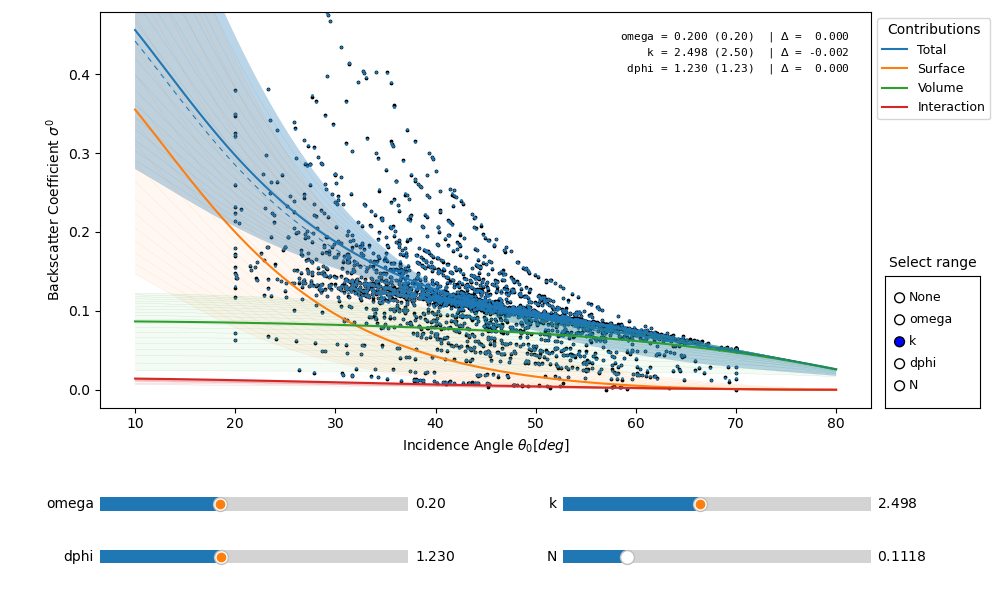

In [7]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in found_params}
# pick the measurement for which you want to analyze the components
R.update_params(phi=0)

ana = R.analyze(param_dict=analyze_params, range_parameter="k")
# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega", "k", "dphi"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega", "k", "dphi"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)